# Browse Runs

Interactive notebook for monitoring training progress and visualizing runs.

**Usage:** Re-run this notebook to get the latest training status.

**CLI commands** (from `tdmpc2/` directory):
```bash
python -m discover status     # Quick status overview
python -m discover running    # Currently running tasks
python -m discover tasks      # All tasks with progress (225 official tasks)
python -m discover tasks --all  # Include non-official tasks (smoke-test, etc.)
python -m discover restart    # Show restart commands (add --submit to run)
python -m discover --help     # All available commands
```

## Setup

In [1]:
from pathlib import Path
import sys

# Ensure repo root is importable
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Change to ROOT for CLI commands
%cd {ROOT}

/home/projects/dharel/nadavt/repos/newt/tdmpc2


/home/projects/dharel/nadavt/.conda/envs/newt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd

# Notebook display defaults: don't truncate long outputs with `...`
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
np.set_printoptions(threshold=np.inf)

In [3]:
# Import the discover API
from discover import load_df, get_target_step
from discover.plots import training_overview, plot_max_steps, progress_by_domain

TARGET_STEP = get_target_step()
print(f"TARGET_STEP: {TARGET_STEP:,}")

TARGET_STEP: 5,000,000


## Load Runs Data

In [4]:
# load_df() loads merged runs from local logs + wandb (uses cache by default)
# Set refresh=True to force re-fetch from sources
df_all = load_df(refresh=True)
print(f"Loaded {len(df_all)} runs")

Scanning local logs (/home/projects/dharel/nadavt/repos/newt/tdmpc2/logs)...
  733 local runs found        


Loaded 733 runs


## Training Progress Overview

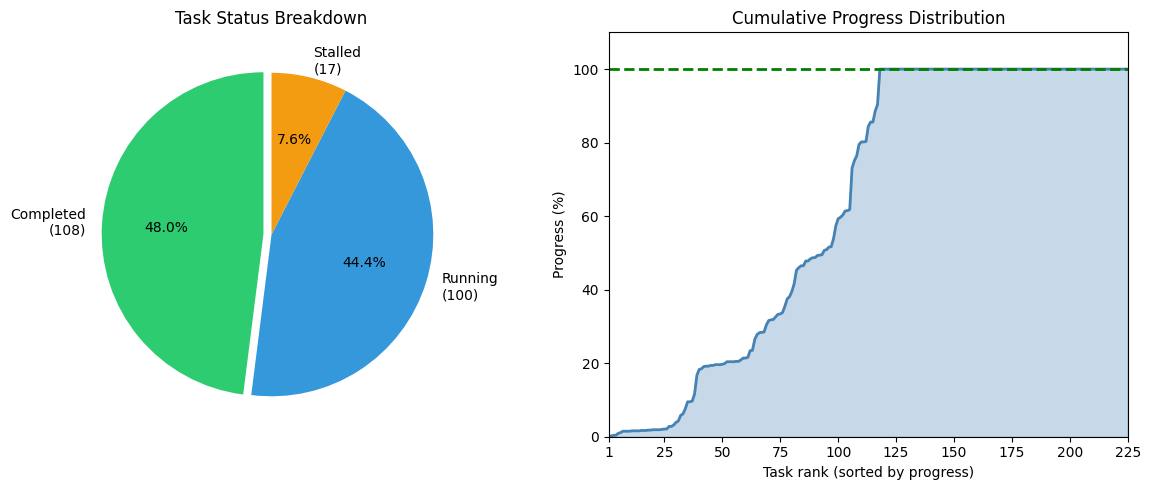

                 TRAINING PROGRESS SUMMARY                  
  Total tasks:            225  (from tasks.json)
  Target step:         5,000,000
------------------------------------------------------------
  🟢 ✅ Completed:         108 (48.0%)
  🔵 🏃 Running:           100 (44.4%)  <- active (see discover.liveness)
  🟠 ⏸️  Stalled:            17 (7.6%)  <- needs restart
  🔴 ❌ Not Started:         0 (0.0%)
------------------------------------------------------------
  Average progress:      63.3%
  Median progress:       84.4%
  Min steps:            9,898
  Max steps:           5,000,002


In [5]:
# training_overview: pie chart + summary stats
# Categories are computed via the central liveness + aggregation logic in `discover.liveness`.
training_overview(df_all, target_step=TARGET_STEP)

## Currently Running / Needs Restart (CLI)


In [6]:
# CLI: list all tasks with progress, running count, and status
# Options: --format json|csv, --not-started, --stalled, --running, --completed
!python -m discover tasks

                                        ALL TASKS                                         
Task                                            Progress     Max Step   HB   WB          Status
------------------------------------------------------------------------------------------
   ms-pick-golf-ball                               0.2%        9,898    0    0       🟠 stalled
   ms-pick-soccer-ball                             0.2%       12,198    1    0       🔵 running
   ms-pick-cup                                     0.4%       21,148    0    0       🟠 stalled
   ms-pick-rubiks-cube                             0.4%       18,598    0    0       🟠 stalled
   rd-flat-block-in-bin                            0.9%       46,816    4    0       🔵 running
   rd-push-green                                   1.1%       57,364    3    0       🔵 running
   ms-push-can                                     1.5%       74,594    3    0       🔵 running
   ms-push-pear                                    1.5%  

In [7]:
# CLI: progress aggregated by domain prefix (walker-*, mw-*, etc.)
!python -m discover domains

                               PROGRESS BY DOMAIN                               
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
acrobot                     1          1         100.0%         100.0%
pendulum                    2          2         100.0%         100.0%
reacher                     4          4         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
cup                         2          2         100.0%         100.0%
finger                      3          3         100.0%         100.0%
fish                        1          1         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
hopper                      3          3         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
quadruped                   2          2         100.0%  

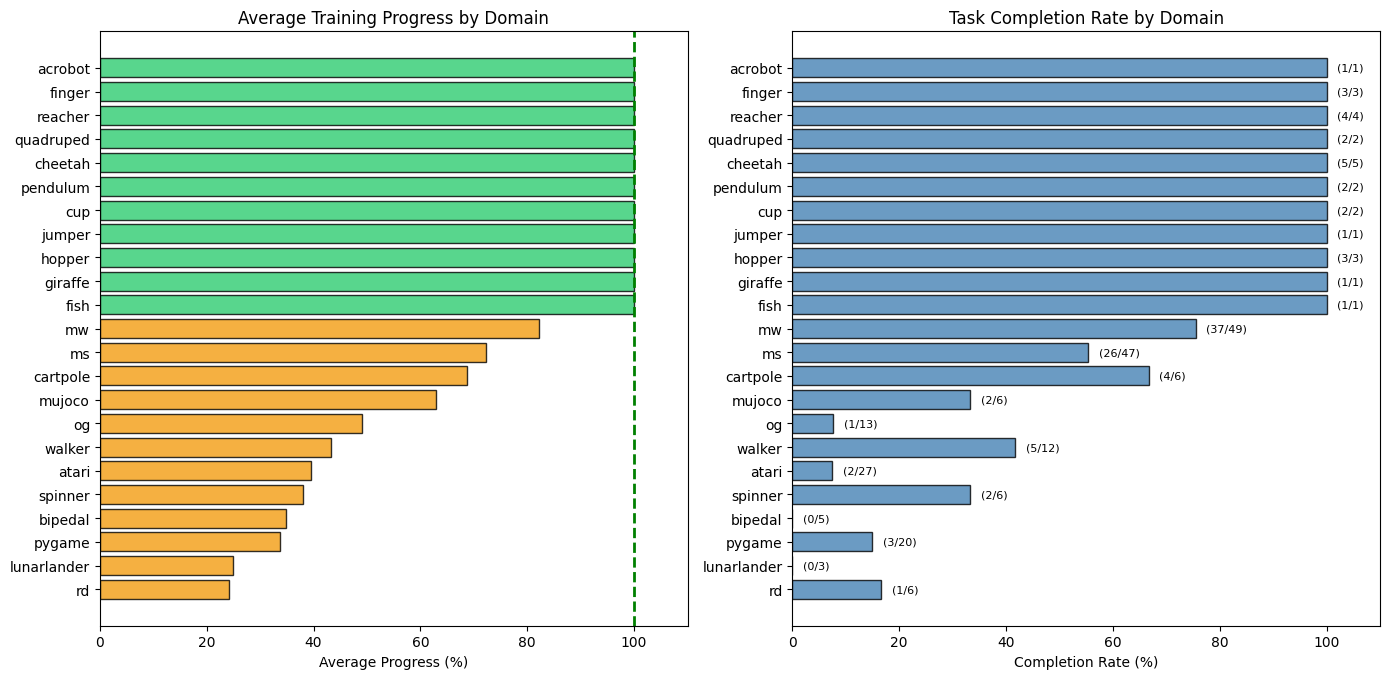


Domain Summary:
--------------------------------------------------------------------------------
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
acrobot                     1          1         100.0%         100.0%
fish                        1          1         100.0%         100.0%
finger                      3          3         100.0%         100.0%
reacher                     4          4         100.0%         100.0%
quadruped                   2          2         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
pendulum                    2          2         100.0%         100.0%
cup                         2          2         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
hopper                      3          3         100.0%         100.0%
giraffe                     1          1

In [8]:
# progress_by_domain: visualization of domain-level progress
progress_by_domain(df_all, target_step=TARGET_STEP)

## 4. Currently Running


In [9]:
# CLI: shows tasks that are currently considered active by `discover.liveness`.
# (Any source-specific signals shown are derived from that central logic.)
!python -m discover running

                         RUNNING RUNS SUMMARY                         
  Active runs (WB):               0
  Active runs (HB):             212
  Stale local 'running':        601  ⚠️  (local-only)
  Tasks with running runs:      104
  Tasks needing restart:         13  ⚠️  (incomplete, no active signal)
  Tasks with stale runs:          0  🔄 (>1 wandb run, from resume)

🏃 CURRENTLY RUNNING TASKS (104 tasks):
   wandb running runs: 0 | alive heartbeats: 212
----------------------------------------------------------------------
Task                                      Wandb     HB     Progress     Max Step
----------------------------------------------------------------------
   ms-pick-soccer-ball                        0      1        0.2%       12,248
   rd-flat-block-in-bin                       0      3        0.9%       46,894
   rd-push-green                              0      3        1.1%       57,364
   ms-push-can                                0      3        1.5%       74,

## 5. Needs Restart

In [10]:
# CLI: shows bsub commands for tasks that need attention, according to `discover.liveness`.
# Add --submit to actually execute the bsub commands
!python -m discover restart

                         RUNNING RUNS SUMMARY                         
  Active runs (WB):               0
  Active runs (HB):             213
  Stale local 'running':        601  ⚠️  (local-only)
  Tasks with running runs:      102
  Tasks needing restart:         15  ⚠️  (incomplete, no active signal)
  Tasks with stale runs:          0  🔄 (>1 wandb run, from resume)

⚠️  TASKS NEEDING RESTART (15 tasks, no active signal; see discover.liveness):
----------------------------------------------------------------------
Task                                         Progress        Max Step     HB  Wandb
----------------------------------------------------------------------
   ms-pick-orange                              90.4%       4,517,812      0      0
   ms-pick-cube-xarm6                          85.6%       4,282,154      0      0
   pygame-landing                              85.6%       4,279,804      0      0
   ms-pick-knife                               84.4%       4,220,240     

In [11]:
# # submitting all non-completed tasks (stalled or not started)
# !python -m discover restart --submit

## 6. Eval Status

In [12]:
# # CLI: list tasks ready for eval (≥50% trained) and their video status
# # Use 'python -m discover eval submit --submit' to generate and submit eval jobs
# !python -m discover eval list

## 7. Collect Videos

In [13]:
# # CLI: collect videos from trained tasks into videos_for_presentation/
# # Options: --min-progress 0.5, --copy (instead of symlinks), --output <dir>
# # Then: rsync -avz server:tdmpc2/discover/videos_for_presentation/ ./videos/
# !python -m discover videos collect